## Features individually predictive of SL between paralog pairs

**Input**: Our training dataset of (non-)SL paralog pairs + all paralog pair features

**Output**:
* Indiv. feature AUCs + avg. precision and M-W / FET as applicable
* Table S5: our training dataset of (non-)SL paralog pairs annotated with the 22 features
* Table S6: all features with descriptions and their associated metrics (AUC, avg. precision, M-W, FET)

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
import scipy.stats as stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import graphing_params as gp
%load_ext autoreload
%autoreload 1
%aimport graphing_params

import os

get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)
get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)

# Input
file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_depmap_pairs = get_local_data_path(['results'], 'depmap_pairs.csv')
file_feature_table = get_local_data_path([], 'feature_table.xlsx') # Descriptions of all the features
file_feature_names = get_local_data_path([],'feature_names.txt')
file_consensus_pairs = get_local_data_path(['processed', 'screen_pairs'], 'consensus_pairs.csv')

# Outputs
file_feature_list = get_local_data_path([], 'feature_list.txt')
file_feature_aucs = get_local_data_path(['results'], 'indiv_feature_aucs.csv')
file_table_s5 = get_local_data_path(['supplemental_files'], 'Table_S5.csv') # training dataset with features
file_table_s6 = get_local_data_path(['supplemental_files'], 'Table_S6.xlsx') # list of features + their metrics

### Data

In [4]:
paralog_annotations = pd.read_csv(file_annot_pairs, float_precision="round_trip")
print('Num annotated pairs:', paralog_annotations.shape[0])

depmap_pairs = pd.read_csv(file_depmap_pairs)
depmap_pairs = pd.merge(depmap_pairs, paralog_annotations)
print('Num SL:', sum(depmap_pairs.SL), '/', depmap_pairs.shape[0])
depmap_pairs[:1]

Num annotated pairs: 36648
Num SL: 126 / 3634


,sorted_gene_pair,SL,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,...,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val
0,AAK1_BMP2K,False,AAK1,BMP2K,ENSG00000115977,ENSG00000138756,22848,55589,True,0.341947,...,False,False,False,False,7,976.25,0.0,False,True,False


#### Features

In [5]:
all_features = pd.DataFrame([
    ['min_sequence_identity',                  'sequence',              1,      0,     0],
    ['max_sequence_identity',                  'sequence',              0,      0,     0],
    ['closest',                                'sequence',              1,      0,     0],  
    ['WGD',                                    'sequence',              1,      0,     0], 
    ['family_size',                            'sequence',              1,      0,     0],          
    ['cds_length_ratio',                       'sequence',              1,      0,     0],
    ['shared_domains',                         'sequence',              1,      0,     0], 
    ['has_pombe_ortholog',                     'sequence',              1,      1,     0], 
    ['has_pombe_ortholog_ip',                  'sequence',              0,      0,     0], 
    ['has_essential_pombe_ortholog',           'sequence',              1,      1,     0],
    ['has_single_essential_pombe_ortholog',    'sequence',              0,      1,     0],
    ['has_cerevisiae_ortholog',                'sequence',              1,      1,     0],   
    ['has_cerevisiae_ortholog_ip',             'sequence',              0,      0,     0],   
    ['has_essential_cerevisiae_ortholog',      'sequence',              1,      1,     0],
    ['has_single_essential_cerevisiae_ortholog','sequence',             0,      1,     0],
    ['conservation_score',                     'sequence',              1,      0,     0],
    ['mean_age',                               'sequence',              1,      0,     0],
    ['either_in_complex',                      'neighborhood',          1,      0,     0],       
    ['mean_complex_essentiality',              'neighborhood',          1,      0,     0],            
    ['colocalisation',                         'neighborhood',          1,      0,     0],         
    ['interact',                               'neighborhood',          1,      0,     1],         
    ['n_total_ppi',                            'neighborhood',          1,      0,     1],
    ['fet_ppi_overlap',                        'neighborhood',          1,      0,     1],     
    ['shared_ppi_mean_essentiality',           'neighborhood',          1,      0,     0],              
    ['gtex_spearman_corr',                     'expression',            1,      0,     0],
    ['gtex_min_mean_expr',                     'expression',            1,      0,     0],     
    ['gtex_max_mean_expr',                     'expression',            1,      0,     0]  
], columns=['feature','category', 'include', 'yeast', 'ppi'])

print('Num features:', all_features[all_features.include==1].shape[0])
all_features[all_features.include==1].reset_index(drop=True)[['feature','category']].to_csv(file_feature_list, index=0)
all_features[:1]

Num features: 22


,feature,category,include,yeast,ppi
0,min_sequence_identity,sequence,1,0,0


In [6]:
# Nice labels for all features - for graphs
feature_name_map = pd.read_csv(file_feature_names, sep='\t')
feature_name_map[:1]

,simple_name,feature,category
0,Sequence Identity,min_sequence_identity,Sequence


In [7]:
# Save our dataset + feature annotations as Table S5
features = list(all_features[all_features.include==1].feature)
table_s5 = depmap_pairs[['sorted_gene_pair','A1','A2','A1_entrez','A2_entrez','SL'] + features]
assert(table_s5.shape[0]==depmap_pairs.shape[0])
assert(table_s5.shape[0]==3634)
assert(sum(table_s5.SL)==sum(depmap_pairs.SL))
display(table_s5[:2])
table_s5.to_csv(file_table_s5, index=0)

,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,SL,min_sequence_identity,closest,WGD,family_size,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,shared_ppi_mean_essentiality,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,AAK1_BMP2K,AAK1,BMP2K,22848,55589,False,0.341947,True,False,2,...,False,0.0,0.0,False,77,21.867726,0.479952,0.261701,6.713555,6.761786
1,ABCA1_ABCA7,ABCA1,ABCA7,19,10347,False,0.498894,False,True,12,...,False,0.0,0.0,False,31,0.000000,0.000000,0.027520,15.168588,15.825617


### ROC-AUC + Avg. Precision for indiv. features

In [8]:
# Each feature tried as positive / negative, retaining the direction providing an AUC > 0.5
def calc_feature_roc_aucs(pairs, features_df, feature_name_map=pd.DataFrame()):
    feature_aucs = pd.DataFrame(columns=['roc_auc','roc_auc_mean','roc_auc_sem', 'avg_precision',
                                         'avg_precision_mean','avg_precision_sem','category','direction'])
    for idx, row in features_df.iterrows():
        feature = row.feature
        
        # ROCAUC for all pairs, for both pos/neg feature values
        pos_score = roc_auc_score(pairs.SL, pairs[feature])
        neg_score = roc_auc_score(pairs.SL, -pairs[feature])
        
        # Want to test 10 random splits of the data
        cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10, random_state=11)
        roc_aucs = []; APs = []
        roc_auc = 0; avg_precision = 0
        # Use pos or neg feature values, depending on higher ROCAUC
        if pos_score > neg_score:
            roc_auc = pos_score
            direction = '+'
            avg_precision = average_precision_score(pairs.SL, pairs[feature])
            for train_idx, test_idx in cv.split(pairs[feature], pairs.SL): 
                roc_aucs.append(roc_auc_score(pairs.iloc[test_idx].SL, pairs.iloc[test_idx][feature]))
                APs.append(average_precision_score(pairs.iloc[test_idx].SL, pairs.iloc[test_idx][feature]))
        else:
            roc_auc = neg_score
            direction = '-'
            avg_precision = average_precision_score(pairs.SL, -pairs[feature])
            for train_idx, test_idx in cv.split(pairs[feature], pairs.SL):
                roc_aucs.append(roc_auc_score(pairs.iloc[test_idx].SL, -pairs.iloc[test_idx][feature]))
                APs.append(average_precision_score(pairs.iloc[test_idx].SL, -pairs.iloc[test_idx][feature]))

        # Also calculate the standard error of the mean for ROCAUC and AP
        feature_aucs.loc[feature] = [roc_auc, np.mean(roc_aucs), stats.sem(roc_aucs), 
                                     avg_precision, np.mean(APs), stats.sem(APs), row.category, direction]
    
    feature_aucs = feature_aucs.reset_index().rename(columns={'index':'feature'})
    if feature_name_map.shape[0]>0:
        feature_aucs = pd.merge(feature_aucs, feature_name_map[['feature','simple_name']])
    return feature_aucs

#### Draw indiv feature AUC/AP graph

In [9]:
def draw_feature_auc_chart(feature_aucs, axes, color_dict, feat_col='simple_name', with_error=True, 
                           xlim=0.752, xlim2=(0.03, 0.11)):
    # ROC-AUC
    sns.barplot(x='roc_auc', y=feat_col, hue='category', data=feature_aucs, ax=axes[0], dodge=False,
                palette=list(color_dict.values()), hue_order=list(color_dict.keys()), saturation=1)
    if with_error:
        axes[0].errorbar(y=feature_aucs[feat_col], x=feature_aucs.roc_auc, xerr=feature_aucs.roc_auc_sem, 
                         fmt='none', color='black', linewidth=0.8, capsize=0)
    # AP
    sns.pointplot(x='avg_precision', y=feat_col, hue='category', data=feature_aucs, ax=axes[1], dodge=False,
                  join=False, palette=list(color_dict.values()), hue_order=list(color_dict.keys()), saturation=1, 
                  scale=1.1, ci=None)
    if with_error:
        axes[1].errorbar(y=feature_aucs[feat_col], x=feature_aucs.avg_precision, xerr=feature_aucs.avg_precision_sem, 
                         fmt='none', color=[color_dict[c] for c in feature_aucs.category], linewidth=0.8)
    
    axes[0].grid(axis='x'); axes[1].grid(axis='x')
    axes[0].set_xlim([0.5, xlim])
    axes[0].legend(loc='lower right', fontsize=9, bbox_to_anchor=(1.06,0), markerscale=0.5)
    axes[0].tick_params(axis='y', which='both', length=0)
    axes[0].set_xlabel('ROC AUC'); axes[0].set_ylabel('')
    
    axes[1].set_xlim([xlim2[0], xlim2[1]])
    axes[1].set_ylim([feature_aucs.shape[0]-0.4, -0.6])
    axes[1].legend().remove()
    axes[1].tick_params(axis='y', which='both', length=0)
    axes[1].set_xlabel('Avg. precision'); axes[1].set_ylabel('')

In [10]:
color_dict = dict(zip(['sequence', 'neighborhood', 'expression'], gp.get_palette('okabe-ito-3')))

In [11]:
feature_aucs = calc_feature_roc_aucs(depmap_pairs, all_features[(all_features.include==1)], feature_name_map)
feature_aucs = feature_aucs.sort_values('roc_auc', ascending=False)

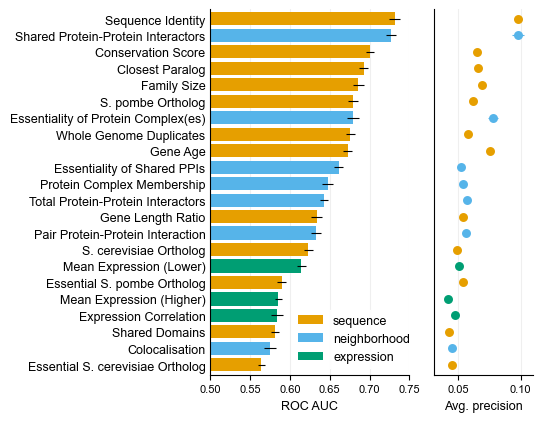

In [12]:
f, axes = plt.subplots(1, 2, figsize=(5.5,4.3), sharey=True, gridspec_kw={'width_ratios': [2, 1]})    
draw_feature_auc_chart(feature_aucs, axes, color_dict, feat_col='simple_name', xlim=0.75, xlim2=(0.03, 0.11))
gp.set_axis_props(axes[0], ytick_fontsize=9)
plt.tight_layout(h_pad=0.4)
plt.savefig("../figures/for_paper/indiv_feature_aucs.svg", bbox_inches="tight", dpi=100)

#### Yeast ortholog features
To compare single essential vs. any essential yeast ortholog

In [13]:
print('AP pombe ortholog=%.3f' % (feature_aucs[feature_aucs.feature=='has_pombe_ortholog'].avg_precision),
      'vs. essential pombe ortholog=%.3f' % (feature_aucs[feature_aucs.feature=='has_essential_pombe_ortholog'].avg_precision))

print('AP cerevisiae ortholog=%.3f' % (feature_aucs[feature_aucs.feature=='has_cerevisiae_ortholog'].avg_precision),
      'vs. essential cerevisiae ortholog=%.3f' % 
      (feature_aucs[feature_aucs.feature=='has_essential_cerevisiae_ortholog'].avg_precision))

AP pombe ortholog=0.062 vs. essential pombe ortholog=0.053
AP cerevisiae ortholog=0.049 vs. essential cerevisiae ortholog=0.045


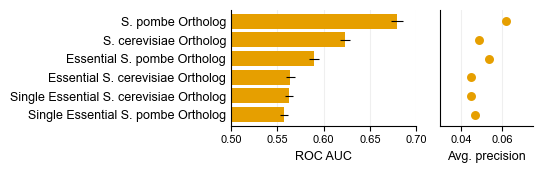

In [14]:
# Filter and merge in feature labels
yeast_aucs = calc_feature_roc_aucs(depmap_pairs, all_features[(all_features.yeast==1)], feature_name_map)
yeast_aucs = yeast_aucs.sort_values('roc_auc', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(5.5,1.8), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
draw_feature_auc_chart(yeast_aucs, axes, color_dict={'sequence':gp.get_color('orange')}, xlim=0.7, xlim2=(0.03,0.075))
gp.set_axis_props(axes[0], ytick_fontsize=9)
axes[0].legend().remove()
plt.tight_layout()
plt.savefig("../figures/for_paper/yeast_feature_aucs.svg", bbox_inches="tight", dpi=100)

#### Paralog families

Median family size SL pairs: 5.0
Median family size non-SL pairs: 8.0


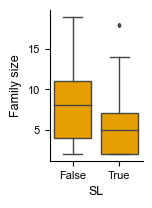

In [15]:
print('Median family size SL pairs:', depmap_pairs[depmap_pairs.SL].family_size.median())
print('Median family size non-SL pairs:', depmap_pairs[~depmap_pairs.SL].family_size.median())

f, ax = plt.subplots(1, 1, figsize=(1.2,2))
sns.boxplot(y=depmap_pairs.family_size, x=depmap_pairs.SL, ax=ax, fliersize=2, color=color_dict['sequence'], saturation=1)
_ = ax.set_ylabel('Family size')

#### Shared domains

With all shared domains: 66.24%


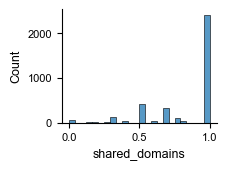

In [16]:
f, axes = plt.subplots(1, 1, figsize=(2,1.5))
sns.histplot(depmap_pairs.shared_domains)
print('With all shared domains: %.2f%%' % (sum(depmap_pairs.shared_domains==1)/depmap_pairs.shape[0]*100))

#### PPI & protein complex features

In [17]:
# Some metrics related to the above graph
print('Protein complex essentiality AP=%.3f' % (feature_aucs[feature_aucs.feature=='mean_complex_essentiality'].avg_precision))
print('Shared PPI essentiality AP=%.3f' % (feature_aucs[feature_aucs.feature=='shared_ppi_mean_essentiality'].avg_precision))

print('Total PPI AP=%.3f, AUC=%.3f' % (feature_aucs[feature_aucs.feature=='n_total_ppi'].avg_precision,
                                       feature_aucs[feature_aucs.feature=='n_total_ppi'].roc_auc))
print('Shared PPI AP=%.3f, AUC=%.3f' % (feature_aucs[feature_aucs.feature=='fet_ppi_overlap'].avg_precision,
                                       feature_aucs[feature_aucs.feature=='fet_ppi_overlap'].roc_auc))

Protein complex essentiality AP=0.078
Shared PPI essentiality AP=0.052
Total PPI AP=0.057, AUC=0.643
Shared PPI AP=0.098, AUC=0.727


### M-W and FET for each feature in SL vs. non-SL paralog pairs

In [18]:
labels = ['Min. % sequence identity', 'that are closest paralogs', 'that are WGD', 'Family size', 'CDS length ratio',
          'Shared domains', 'w/ S. pombe ortholog', 'w/ essential S. pombe ortholog', 
          'w/ S. cerevisiae ortholog', 'w/ essential\nS. cerevisiae ortholog',
          'Conservation score', 'Gene age', 'in protein complex', 'Mean complex essentiliaty',
          'FET -log10 p for colocalisation',
          'that interact', 'Total num. PPIs', 'FET -log10 p for PPIs overlap', 'Mean essentiality of shared PPIs',
          'Expression correlation', 'Mean expression (lower)', 'Mean expression (higher)']
display(dict(zip(all_features[all_features.include==1].feature, labels)))

{'min_sequence_identity': 'Min. % sequence identity',
 'closest': 'that are closest paralogs',
 'WGD': 'that are WGD',
 'family_size': 'Family size',
 'cds_length_ratio': 'CDS length ratio',
 'shared_domains': 'Shared domains',
 'has_pombe_ortholog': 'w/ S. pombe ortholog',
 'has_essential_pombe_ortholog': 'w/ essential S. pombe ortholog',
 'has_cerevisiae_ortholog': 'w/ S. cerevisiae ortholog',
 'has_essential_cerevisiae_ortholog': 'w/ essential\nS. cerevisiae ortholog',
 'conservation_score': 'Conservation score',
 'mean_age': 'Gene age',
 'either_in_complex': 'in protein complex',
 'mean_complex_essentiality': 'Mean complex essentiliaty',
 'colocalisation': 'FET -log10 p for colocalisation',
 'interact': 'that interact',
 'n_total_ppi': 'Total num. PPIs',
 'fet_ppi_overlap': 'FET -log10 p for PPIs overlap',
 'shared_ppi_mean_essentiality': 'Mean essentiality of shared PPIs',
 'gtex_spearman_corr': 'Expression correlation',
 'gtex_min_mean_expr': 'Mean expression (lower)',
 'gtex_max

In [19]:
def draw_signif_line(ax, x0, x1, y, pval, hd=20):
    h = y/hd
    if pval < 0.0001: text = '$p$=%.1e' % pval
    else: text = '$p$=%.4f' % pval
    ax.plot([x0, x0, x1, x1], [y+h, y+2*h, y+2*h, y+h], lw=1, c='#666')
    ax.text((x0+x1)*.5, y+2.5*h, text, ha='center', va='bottom', color='#666', fontsize=8)

def draw_boolean_graph(feature, ax, category, label=None, draw_signif=True):
    color = color_dict[category]
    ctab = pd.crosstab(depmap_pairs.SL, depmap_pairs[feature])
    fet_pval = stats.fisher_exact(ctab)[1]
    ctab = ctab.apply(lambda x: x/x.sum()*100, axis=1).loc[:,True]
    ctab.plot.bar(stacked=True, ax=ax, width=0.85, rot=0, color=['#AAAAAA', color])
    ax.set_ylabel(('% '+label if label != None else '% '+feature))
    ax.set_xlabel('SL pair')
    #txt = '**' if fet_pval < 0.00001 else '*' if fet_pval < 0.01 else 'ns'
    if draw_signif:
        draw_signif_line(ax, 0, 1, ctab.max(), fet_pval)
        
def compute_upper_whisker(df, feature):
    Q1 = df[feature].quantile(q=0.25)
    Q3 = df[feature].quantile(q=0.75)
    IQR = Q3-Q1
    return df[df[feature]<=(Q3+1.5*IQR)][feature].max()
    
def draw_cont_graph(feature, ax, category, label=None, fliers=True, draw_signif=True, hd=20):
    color = color_dict[category]
    df = depmap_pairs.dropna(subset=[feature])
    sns.boxplot(y=feature, x='SL', data=df, ax=ax, linewidth=0.98, saturation=1, showfliers=fliers, 
                fliersize=1, palette=['#AAAAAA', color], medianprops={'color':'black', 'linewidth':0.98})
    # boxprops={'edgecolor':'black'}, whiskerprops={'color':'black'}, capprops={'color':'black'}
    ax.set_ylabel((label if label != None else feature))
    ax.set_xlabel('SL pair')
    if draw_signif:
        pval = stats.mannwhitneyu(df[df.SL][feature], df[~df.SL][feature], alternative="two-sided")[1]
        upper_whisker = max(compute_upper_whisker(df[df.SL], feature), compute_upper_whisker(df[~df.SL], feature))
        draw_signif_line(ax, 0, 1, upper_whisker, pval, hd)

def draw_feature_graph(feature, ax, category, label=None, draw_signif=True, fliers=False, hd=20):
    if depmap_pairs[feature].dtype == 'bool':
        draw_boolean_graph(feature, ax, category, label, draw_signif=draw_signif)
    elif depmap_pairs[feature].dtype == 'float64' or  depmap_pairs[feature].dtype == 'int64':
        draw_cont_graph(feature, ax, category, label, fliers=fliers, draw_signif=draw_signif, hd=hd)

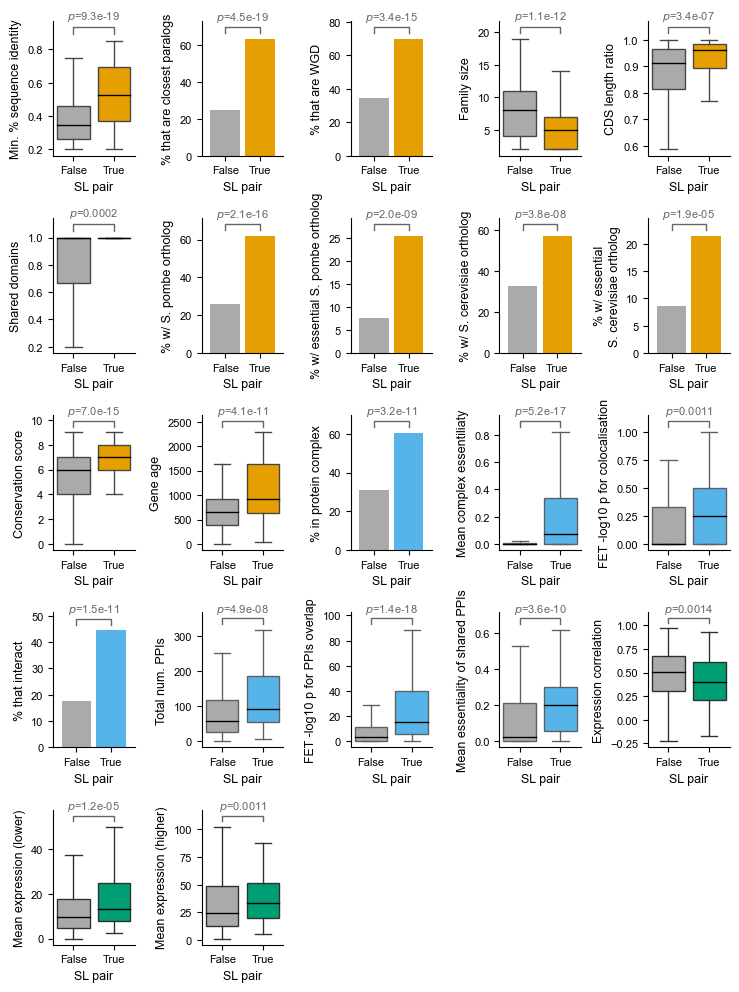

In [20]:
f, ax = plt.subplots(5,5, figsize=(7.6,10))
ax=ax.flatten()
for row in all_features[all_features.include==1].reset_index(drop=True).iterrows():
    if row[1].feature=='cds_length_ratio': hd=40
    else: hd=20
    draw_feature_graph(row[1].feature, ax[row[0]], category=row[1].category, label=labels[row[0]], hd=hd)
plt.tight_layout()
for i in range(22,25): ax[i].axis('off')
f.savefig('../figures/for_paper/feat_signif.svg', bbox_inches='tight', dpi=300)

### Export ROC AUC, avg precision, M-W p and FET p for each feature

In [21]:
full_feature_aucs = calc_feature_roc_aucs(depmap_pairs, all_features[(all_features.include==1)])
print('N AUC values:', full_feature_aucs.shape[0])
full_feature_aucs[:1]

N AUC values: 22


,feature,roc_auc,roc_auc_mean,roc_auc_sem,avg_precision,avg_precision_mean,avg_precision_sem,category,direction
0,min_sequence_identity,0.731492,0.731555,0.00669,0.097999,0.106054,0.003392,sequence,+


In [22]:
def calc_feature_FET(feature):
    if depmap_pairs[feature].dtype == 'bool':
        ctab = pd.crosstab(depmap_pairs.SL, depmap_pairs[feature])
        return stats.fisher_exact(ctab)[1]
    return float('nan')

def calc_feature_MW(feature):
    if depmap_pairs[feature].dtype == 'float64' or  depmap_pairs[feature].dtype == 'int64':
        df = depmap_pairs.dropna(subset=[feature])
        return stats.mannwhitneyu(df[df.SL][feature], df[~df.SL][feature], alternative="two-sided")[1]
    return float('nan')

In [23]:
# Save feature AUCs in feature table as Table S6
feature_table = pd.read_excel(file_feature_table, usecols="A:E")
feature_table = pd.merge(feature_table, full_feature_aucs[['feature','roc_auc',
                                                           'avg_precision']].rename(columns={'feature':'Feature'}))
feature_table = feature_table.assign(FET_pval = feature_table.Feature.apply(calc_feature_FET))
feature_table = feature_table.assign(MW_pval = feature_table.Feature.apply(calc_feature_MW))
table_s6 = feature_table.rename(columns={'roc_auc':'ROC AUC', 'avg_precision':'Avg. Precision',
                                         'FET_pval':'FET p-value', 'MW_pval':'M-W p-value'})

In [26]:
table_s6

,Simple Name,Feature,Category,Description,Source,ROC AUC,Avg. Precision,FET p-value,M-W p-value
0,Sequence Identity,min_sequence_identity,Sequence,The minimum of: the percent of A1's protein-co...,Ensembl,0.731492,0.097999,NaN,9.337756e-19
1,Closest Paralog,closest,Sequence,Whether A1 and A2 are each other's closest par...,Ensembl,0.692745,0.065845,4.498892e-19,NaN
2,Family Size,family_size,Sequence,The number of paralogs in the family that incl...,Ensembl,0.685889,0.068662,NaN,1.079726e-12
3,Gene Length Ratio,cds_length_ratio,Sequence,The ratio of the lengths of A1 and A2's coding...,Ensembl,0.633536,0.053346,NaN,3.380043e-07
4,Whole Genome Duplicates,WGD,Sequence,Whether A1 and A2 originate from a whole genom...,"Makino and McLysaght, OHNOLOGS v2",0.676031,0.057625,3.396190e-15,NaN
5,S. pombe Ortholog,has_pombe_ortholog,Sequence,Whether A1 and/or A2 have an ortholog in S. po...,PomBase,0.679393,0.061933,2.057392e-16,NaN
6,Essential S. pombe Ortholog,has_essential_pombe_ortholog,Sequence,Whether A1 and/or A2 have an essential ortholo...,Kim et al,0.589498,0.053416,1.982670e-09,NaN
7,S. cerevisiae Ortholog,has_cerevisiae_ortholog,Sequence,Whether A1 and/or A2 have an ortholog in S. ce...,Ensembl,0.622943,0.048750,3.839091e-08,NaN
8,Essential S. cerevisiae Ortholog,has_essential_cerevisiae_ortholog,Sequence,Whether A1 and/or A2 have an essential ortholo...,OGEE,0.563956,0.044775,1.905998e-05,NaN
9,Conservation Score,conservation_score,Sequence,"Number of species, out of nine, in which A1 an...","Ensembl, InParanoid",0.700957,0.064994,NaN,7.048332e-15


In [27]:
table_s6.to_excel(file_table_s6, index=0)